In [1]:
# Cell : clean auto-generated requirements file  (run FIRST!)
# -----------------------------------------------------------
import pathlib, shutil, re, textwrap, sys, os

REQ_PATH = pathlib.Path("/kaggle/requirements/input_requirements.txt")
if REQ_PATH.is_file():
    cleaned_lines = []
    for line in REQ_PATH.read_text().splitlines():
        line = line.strip()
        if not line or line.startswith("#"):
            continue                    # ← drop blanks / comments
        if not line.startswith("pip install"):
            # keep it but comment it out so the helper ignores it
            line = f"# {line}"
        cleaned_lines.append(line)

    REQ_PATH.write_text("\n".join(cleaned_lines) + ("\n" if cleaned_lines else ""))

    print(f"[INFO] requirements cleaned – {len(cleaned_lines)} valid "
          f"pip-install line(s) kept.")
else:
    print(f"[INFO] {REQ_PATH} not found – nothing to clean.")

[INFO] /kaggle/requirements/input_requirements.txt not found – nothing to clean.


In [2]:
%%bash
# Cell: show what’s inside every mounted Kaggle dataset  🔍
# --------------------------------------------------------
echo -e "\n📂  Listing the first two levels of /kaggle/input …\n"

# Change depth (-maxdepth) if you want more or fewer levels
find /kaggle/input -maxdepth 2 -mindepth 1 -print | sed 's|^|  |'

echo -e "\n✅  Done.\n"


📂  Listing the first two levels of /kaggle/input …

  /kaggle/input/biopython-1-85
  /kaggle/input/biopython-1-85/biopython-1.85-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  /kaggle/input/anybadge-1-16-0
  /kaggle/input/anybadge-1-16-0/anybadge-1.16.0-py3-none-any.whl
  /kaggle/input/anybadge-1-16-0/anybadge-1.16.0
  /kaggle/input/pytest-8-3-4
  /kaggle/input/pytest-8-3-4/pytest-8.3.4-py3-none-any.whl
  /kaggle/input/stanford-rna-3d-folding
  /kaggle/input/stanford-rna-3d-folding/MSA
  /kaggle/input/stanford-rna-3d-folding/sample_submission.csv
  /kaggle/input/stanford-rna-3d-folding/validation_sequences.csv
  /kaggle/input/stanford-rna-3d-folding/MSA_v2
  /kaggle/input/stanford-rna-3d-folding/test_sequences.csv
  /kaggle/input/stanford-rna-3d-folding/train_labels.v2.csv
  /kaggle/input/stanford-rna-3d-folding/validation_labels.csv
  /kaggle/input/stanford-rna-3d-folding/train_labels.csv
  /kaggle/input/stanford-rna-3d-folding/train_sequences.csv
  /kaggle/input/stanfo

In [3]:
%%bash
# Cell : offline installs that match the *current* wheel set (lean version)
# -----------------------------------------------------------------------
set -euo pipefail

# ── let pip look inside EVERY sub-folder of /kaggle/input ───────────────
WHEEL_ROOT="/kaggle/input"
FIND_LINKS_ARGS=""
for d in "$WHEEL_ROOT" "$WHEEL_ROOT"/*; do
  FIND_LINKS_ARGS+=" --find-links $d"
done

p () {                 # quiet install; warn (don’t die) if something fails
  # shellcheck disable=SC2086
  pip install --no-index $FIND_LINKS_ARGS --quiet "$@" \
  || echo "[WARN] install failed → skipped: $*"
}

# ────────────────────────────────────────────────────────────────────────
# 1) Core scientific stack
# ────────────────────────────────────────────────────────────────────────
p numpy==1.24.3
p pandas==2.2.3
p scipy==1.10.1
p tqdm==4.67.1
p seaborn==0.12.2
p biopython==1.85
p torch               # pre-installed in the Kaggle image

# ────────────────────────────────────────────────────────────────────────
# 2)  ML / NLP stack
# ────────────────────────────────────────────────────────────────────────
p huggingface_hub==0.31.1      # needs hf-xet (you already uploaded)
p transformers==4.51.3
p pytorch_lightning==2.5.0.post0   # gives us Lightning-core features

# ────────────────────────────────────────────────────────────────────────
# 3)  Extra deps *rna_predict* really imports
# ────────────────────────────────────────────────────────────────────────
p lightning-utilities==0.11.2  # comes with PL wheel but list explicitly
p datasets==3.6.0
p einops==0.8.1
p hypothesis==6.131.15
p black==25.1.0                # needs pathspec 0.12.1 → you uploaded both
p pathspec==0.12.1
p isort==6.0.1
p ruff==0.11.9
p mss==10.0.0
p mdanalysis==2.9.0
p mmtf-python==1.1.3
p GridDataFormats==1.0.2
p mrcfile==1.5.4
p lxml==5.4.0
p dearpygui==2.0.0
p py-cpuinfo==9.0.0
p Pillow                        # pillow-11-2-1 wheel present
p exit-codes==1.3.0             # small helper used by HF-Hub 0.31+

# ────────────────────────────────────────────────────────────────────────
# 4)  Config utilities
# ────────────────────────────────────────────────────────────────────────
p hydra-core==1.3.2
p omegaconf==2.3.0
p ml_collections==1.1.0         # required by Protenix

# ────────────────────────────────────────────────────────────────────────
# 5)  rna-predict itself  (no-deps so nothing reaches PyPI)
# ────────────────────────────────────────────────────────────────────────
pip install --no-index --no-deps --quiet \
  /kaggle/input/rna-structure-predict/rna_predict-1.0.0-py3-none-any.whl

# ────────────────────────────────────────────────────────────────────────
# 6)  Protenix 0.4.6  (wheel, but ignore its heavy deps like RDKit)
# ────────────────────────────────────────────────────────────────────────
pip install --no-index --no-deps --quiet \
  /kaggle/input/protenix-0-4-6/protenix-0.4.6-py3-none-any.whl \
  || echo "[WARN] Protenix wheel install failed."

# ────────────────────────────────────────────────────────────────────────
# 7)  Runtime shim: make “import lightning” point to pytorch_lightning
# ────────────────────────────────────────────────────────────────────────
python - <<'PY'
import sys, importlib, types
try:
    import pytorch_lightning as pl
    sys.modules.setdefault("lightning", pl)
except ImportError:
    print("[WARN] pytorch_lightning missing – shim not created")
PY

echo "✅  Offline wheel install phase complete."

✅  Offline wheel install phase complete.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
bayesian-optimization 2.0.3 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
featuretools 1.31.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
langchain 0.3.12 requires async-timeout<5.0.0,>=4.0.0; python_version < "3.11", but you have async-timeout 5.0.1 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.3 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.3 which is incompatible.
mlxtend 0.23.3 requires

In [8]:
# ---
# Cell: ALL-IN-ONE Environment Setup  (no uninstalls, no online pip)
# ---

import sys, subprocess, shutil, os, platform

def run_and_print(cmd):
    res = subprocess.run(cmd, capture_output=True, text=True)
    print(res.stdout, end="")
    if res.stderr:
        print(res.stderr, end="")

# ══════ 1)  System information (unchanged) ════════════════════════════════
print("\n=== [System Information] ===")

print("\n[Python Version]")
print(sys.version)

print("\n[Kernel and OS Information]")
run_and_print(["uname", "-a"])

print("\n[CPU Information]")
run_and_print(["lscpu"])

print("\n[Memory Information]")
run_and_print(["free", "-mh"])

print("\n[Disk Information]")
run_and_print(["lsblk"])

print("\n=== [End of System Information] ===\n")

# ══════ 2)  USER CONFIG  ══════════════════════════════════════════════════
RNA_PREDICT_VERSION   = "1.0.0"
BLOCK_SPARSE_WHEEL_IN = (
    "/kaggle/input/block-sparse-wheels/"
    "block_sparse_attn-0.0.1cu118torch2.0cxx11abiTRUE-"
    "cp310-cp310-linux_x86_64.whl"
)
# PEP 440-compliant rename (Torch version tag trimmed)
BLOCK_SPARSE_WHEEL_OUT = (
    "/kaggle/working/"
    "block_sparse_attn-0.0.1+cu118torch2.0-"
    "cp310-cp310-linux_x86_64.whl"
)

# ══════ 3)  Environment-fix helper  ═══════════════════════════════════════
def setup_environment():
    """
    ① Ensure Seaborn (and its deps) is present
    ② Copy & install block_sparse_attn wheel   ← optional; see note below
    ③ Install rna_predict
    ④ Install hydra-core from local wheel
    ⑤ Show final versions of key packages
    """
    # ① Make sure Seaborn is available –
    #    Kaggle base image already has 0.12.2 but we pin it explicitly:
    print("[INFO] Making sure Seaborn is installed…\n")
    run_and_print(["pip", "install", "--quiet", "seaborn==0.12.2"])

    # ② Copy & (optionally) install block_sparse_attn
    if os.path.exists(BLOCK_SPARSE_WHEEL_IN):
        try:
            shutil.copyfile(BLOCK_SPARSE_WHEEL_IN, BLOCK_SPARSE_WHEEL_OUT)
            print("\n[INFO] Copied block-sparse-attn wheel to working dir.")
            print("[INFO] Installing block-sparse-attn (no deps)…\n")
            run_and_print(["pip", "install", "--no-deps", "--quiet", BLOCK_SPARSE_WHEEL_OUT])
        except Exception as e:
            print(f"[WARN] Could not copy/install block-sparse wheel: {e}")
            print("       Continue without it if your code doesn’t need it.")
    else:
        print("[WARN] block-sparse-attn wheel not found in /kaggle/input – skipped.")

    # ③ Install rna_predict (pure-py, so --no-deps is fine)
    rnapred_whl = f"/kaggle/input/rna-structure-predict/" \
                  f"rna_predict-{RNA_PREDICT_VERSION}-py3-none-any.whl"
    if os.path.exists(rnapred_whl):
        print(f"\n[INFO] Installing rna_predict {RNA_PREDICT_VERSION} …\n")
        run_and_print(["pip", "install", "--no-deps", "--quiet", rnapred_whl])
    else:
        print(f"[WARN] {rnapred_whl} not found – skipped.")

    # ④ Install hydra-core from local wheel
    HYDRA_DIR = "/kaggle/input/hydra-core-132whl"
    if os.path.isdir(HYDRA_DIR):
        wheels = [f for f in os.listdir(HYDRA_DIR) if f.endswith(".whl")]
        if wheels:
            for whl in wheels:
                whl_path = os.path.join(HYDRA_DIR, whl)
                print(f"\n[INFO] Installing hydra-core from {whl_path} …\n")
                run_and_print(["pip", "install", "--no-deps", "--quiet", whl_path])
        else:
            print(f"[WARN] No .whl files found in {HYDRA_DIR} – skipped.")
    else:
        print(f"[WARN] {HYDRA_DIR} not found – skipped.")

    # ⑤ Show final versions
    print("\n=== [Final Package Versions] ===")
    for pkg in [
        "torch", "block-sparse-attn", "rna-predict",
        "hydra-core", "numpy", "scipy", "scikit-learn", "seaborn"
    ]:
        run_and_print(["pip", "show", pkg])
    print("=== [End of Final Package Versions] ===\n")

# ══════ 4)  Run it  ═══════════════════════════════════════════════════════
setup_environment()


=== [System Information] ===

[Python Version]
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]

[Kernel and OS Information]
Linux a36bfded09da 6.6.56+ #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux

[CPU Information]
Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        46 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               4
On-line CPU(s) list:                  0-3
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz
CPU family:                           6
Model:                                79
Thread(s) per core:                   2
Core(s) per socket:                   2
Socket(s):                            1
Stepping:                             0
BogoMIPS:                             4400.24
Flags:                          

In [9]:
# -*- coding: utf-8 -*-
"""
Cell 1: ENVIRONMENT SETUP & LOGGING
-----------------------------------
"""
import os
import sys
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


# Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logging.info("Cell 1 complete: Libraries imported and logging initialized.")


In [10]:
"""
Cell 2: DATA IMPORT
-------------------
Here, we read in train/validation/test CSVs and a sample submission from the Kaggle environment.
Adjust the paths if needed for your environment.
"""

# Example file paths
TRAIN_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv"
TRAIN_LABELS_PATH    = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv"
VALID_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv"
VALID_LABELS_PATH    = "/kaggle/input/stanford-rna-3d-folding/validation_labels.csv"
TEST_SEQUENCES_PATH  = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv"
SAMPLE_SUB_PATH      = "/kaggle/input/stanford-rna-3d-folding/sample_submission.csv"

try:
    train_sequences = pd.read_csv(TRAIN_SEQUENCES_PATH)
    train_labels = pd.read_csv(TRAIN_LABELS_PATH)
    validation_sequences = pd.read_csv(VALID_SEQUENCES_PATH)
    validation_labels = pd.read_csv(VALID_LABELS_PATH)
    test_sequences = pd.read_csv(TEST_SEQUENCES_PATH)
    sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

    logging.info("Cell 2 complete: Data loaded successfully.")
except Exception as e:
    logging.error(f"Error loading data: {e}")
    sys.exit(1)

logging.info(f"train_sequences: {train_sequences.shape}, train_labels: {train_labels.shape}")
logging.info(f"validation_sequences: {validation_sequences.shape}, validation_labels: {validation_labels.shape}")
logging.info(f"test_sequences: {test_sequences.shape}, sample_submission: {sample_submission.shape}")

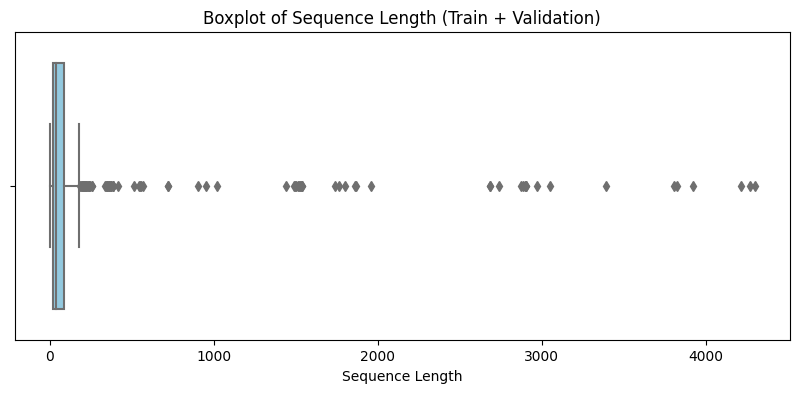

In [11]:
"""
Cell 3: COMBINE TRAIN + VALIDATION & BASIC EDA
----------------------------------------------
We concatenate the train and validation sets to maximize data. 
Then we do a quick EDA check on shapes, missingness, etc.
"""

# Combine sequences and labels
trainval_sequences = pd.concat([train_sequences, validation_sequences], ignore_index=True)
trainval_labels = pd.concat([train_labels, validation_labels], ignore_index=True)

logging.info(f"Combined train+validation sequences: {trainval_sequences.shape}, labels: {trainval_labels.shape}")

# Quick check for missing
logging.info("Missing in combined sequences:\n" + str(trainval_sequences.isnull().sum()))
logging.info("Missing in combined labels:\n" + str(trainval_labels.isnull().sum()))

# Example EDA: sequence length distribution
trainval_sequences['sequence_length'] = trainval_sequences['sequence'].str.len()

plt.figure(figsize=(10,4))
sns.boxplot(x=trainval_sequences['sequence_length'], color='skyblue')
plt.title("Boxplot of Sequence Length (Train + Validation)")
plt.xlabel("Sequence Length")
plt.show()

logging.info("Cell 3 complete: Basic EDA finished.")

In [12]:
"""
Cell 4: HANDLE MISSING COORDINATES & MERGE
------------------------------------------
We replace '-1e18' with np.nan, then merge sequences with labels on target_id.
"""

# Replace -1e18 with np.nan in the labels
for col in ['x_1','y_1','z_1']:
    trainval_labels[col] = trainval_labels[col].replace(-1e18, np.nan)

logging.info("Replaced -1e18 with NaN in trainval_labels for x_1, y_1, z_1.")

# Extract pdb_id, chain_id from ID
trainval_labels['pdb_id']   = trainval_labels['ID'].apply(lambda x: x.split('_')[0])
trainval_labels['chain_id'] = trainval_labels['ID'].apply(lambda x: x.split('_')[1])
trainval_labels['target_id'] = trainval_labels['pdb_id'] + "_" + trainval_labels['chain_id']

# Merge
train_data = pd.merge(trainval_labels, trainval_sequences, on='target_id', how='left')
logging.info(f"Merged train_data shape: {train_data.shape}")

# Quick check
logging.info(f"Missing in x_1: {train_data['x_1'].isnull().sum()}, "
             f"y_1: {train_data['y_1'].isnull().sum()}, "
             f"z_1: {train_data['z_1'].isnull().sum()}")

logging.info("Cell 4 complete: Merged train_data, ready for group-based imputation.")

In [13]:
"""
Cell 5: FEATURE ENGINEERING
---------------------------
Create numerical/categorical features from the 'sequence'.
We'll keep 'resname' from the labels as a valuable feature.
"""

def engineer_features(df):
    """
    Create numerical & (some) categorical features from raw RNA sequence data.
    """
    df = df.copy()
    # Sequence-based
    df['seq_length'] = df['sequence'].str.len()
    df['A_cnt'] = df['sequence'].str.count('A')
    df['C_cnt'] = df['sequence'].str.count('C')
    df['G_cnt'] = df['sequence'].str.count('G')
    df['U_cnt'] = df['sequence'].str.count('U')
    df['begin_seq'] = df['sequence'].str[0]
    df['end_seq']   = df['sequence'].str[-1]
    
    # Di-nucleotide counts (example set)
    for pair in ['AC','AG','AU','CA','CG','CU','GA','GC','GU','UA','UC','UG',
                 'AA','CC','GG','UU']:
        df[f'{pair}_cnt'] = df['sequence'].str.count(pair)

    return df

# Apply feature engineering
train_data = engineer_features(train_data)

logging.info("Feature engineering applied to merged train_data.")

# We'll show an example of newly added columns
example_cols = ['seq_length','A_cnt','C_cnt','G_cnt','U_cnt','begin_seq','end_seq','AC_cnt','AA_cnt']
logging.info(f"Columns after FE sample:\n{train_data[example_cols].head(3)}")

logging.info("Cell 5 complete: Feature engineering done.")

In [14]:
"""
Cell 6: GROUP-BASED IMPUTATION
------------------------------
We impute missing x_1, y_1, z_1 within each (target_id, resname) group.
Finally, if any NAs remain, we fill them with a global median or drop them.
"""

# Perform group-based fill for x_1, y_1, z_1
train_data[['x_1','y_1','z_1']] = (
    train_data
    .groupby(['target_id','resname'])[['x_1','y_1','z_1']]
    .apply(lambda grp: grp.fillna(grp.mean()))
    .reset_index(level=['target_id','resname'], drop=True)
)

# In case any remain after group-based mean fill (e.g. group is all NaN), do a global fill
num_cols = ['x_1','y_1','z_1']
global_imputer = SimpleImputer(strategy='median')
train_data[num_cols] = global_imputer.fit_transform(train_data[num_cols])

# If you'd prefer to drop any leftover NAs instead:
# train_data.dropna(subset=['x_1','y_1','z_1'], inplace=True)

logging.info("Group-based imputation + global median fallback complete.")

# Confirm missing values
logging.info(f"Remaining missing x_1: {train_data['x_1'].isna().sum()}, "
             f"y_1: {train_data['y_1'].isna().sum()}, z_1: {train_data['z_1'].isna().sum()}")

logging.info("Cell 6 complete: Group-based imputation finished.")

In [15]:
"""
Cell 7: PREPARE DATA FOR MODELING
---------------------------------
We'll define the columns we won't use, set up X and y for x_1, y_1, z_1, 
and one-hot encode any relevant categorical columns (including resname).
"""

# Unused columns
unused_cols = [
    'ID','pdb_id','chain_id','resid',
    'x_1','y_1','z_1',
    'sequence','description','temporal_cutoff','all_sequences',
    'target_id'  # key used for merges
]

# We'll keep resname, begin_seq, end_seq as features this time
feature_cols = [col for col in train_data.columns if col not in unused_cols]

# Make a copy
train_df = train_data.copy()

# Convert to categories
for cat_col in ['resname','begin_seq','end_seq']:
    if cat_col in feature_cols:
        train_df[cat_col] = train_df[cat_col].astype('category')

# One-hot encode
train_df = pd.get_dummies(train_df, columns=['resname','begin_seq','end_seq'], drop_first=True)

# Our final set of features
X_cols = [col for col in train_df.columns if col not in unused_cols]

X_full = train_df[X_cols]
y_x_full = train_df['x_1']
y_y_full = train_df['y_1']
y_z_full = train_df['z_1']

logging.info(f"Feature matrix shape: {X_full.shape}")
logging.info("Cell 7 complete: Prepared data for modeling.")

In [16]:
"""
Cell 8: KFold CV for X, Y, Z & Hyperparam Search
------------------------------------------------
We'll do a simplified KFold cross-validation for each coordinate 
to get a sense of good hyperparams, then train final models.
"""

from sklearn.model_selection import KFold, RandomizedSearchCV
import numpy as np

# Example hyperparameter grid (you can expand as needed)
param_dist = {
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [6, 10, 15],
    'n_estimators': [500, 800, 1000],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

def run_random_search(X, y, param_dist, n_iter=5, cv_splits=3):
    """Simple RandomizedSearchCV for an XGBRegressor using GPU in XGBoost >= 2.0."""
    xgb = XGBRegressor(tree_method='hist', device='cuda', random_state=42)
    rsearch = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=cv_splits,
        verbose=1,
        random_state=42
    )
    rsearch.fit(X, y)
    best_model = rsearch.best_estimator_
    logging.info(f"Best params: {rsearch.best_params_}, Best CV Score: {rsearch.best_score_}")
    return best_model, rsearch.best_params_

logging.info("Starting hyperparam search for X coordinate.")
#best_model_x, best_params_x = run_random_search(X_full, y_x_full, param_dist, n_iter=5, cv_splits=3)

logging.info("Starting hyperparam search for Y coordinate.")
#best_model_y, best_params_y = run_random_search(X_full, y_y_full, param_dist, n_iter=5, cv_splits=3)

logging.info("Starting hyperparam search for Z coordinate.")
#best_model_z, best_params_z = run_random_search(X_full, y_z_full, param_dist, n_iter=5, cv_splits=3)

logging.info("Cell 8 complete: RandomizedSearchCV best params found.")

In [17]:
"""
Cell 9: FINAL TRAINING ON FULL DATA
-----------------------------------
Use the best hyperparams for each coordinate found in CV. 
Retrain each coordinate model on all data (X_full, y_*_full).
"""

def get_best_xgb(params):
    """ Return an XGBRegressor with the given params, using GPU. """
    # Here we override or add 'tree_method' to ensure GPU usage
    # We can also specify predictor='gpu_predictor' to accelerate inference on GPU
    model = XGBRegressor(
        **params,
        tree_method='hist',   # or tree_method=params.get('tree_method', 'hist')
        device='cuda',        # ensures GPU usage
        random_state=42
    )
    return model

logging.info("Retraining final model for X coordinate...")
#model_x = get_best_xgb(best_params_x)
#model_x.fit(X_full, y_x_full)

logging.info("Retraining final model for Y coordinate...")
#model_y = get_best_xgb(best_params_y)
#model_y.fit(X_full, y_y_full)

logging.info("Retraining final model for Z coordinate...")
#model_z = get_best_xgb(best_params_z)
#model_z.fit(X_full, y_z_full)

logging.info("Cell 9 complete: Final models trained.")

In [18]:
"""
Cell 10: PREPARE & ENGINEER TEST DATA
-------------------------------------
• Expand test_sequences into (ID, resname, resid)
• Merge residue‑level grid with per‑sequence engineered features
• Align with training feature matrix X_full, fill missing values
"""

# ---------- 1. Expand residue grid ----------
test_expanded = [
    [row["target_id"], nt, i]
    for _, row in test_sequences.iterrows()
    for i, nt in enumerate(row["sequence"], start=1)
]
test_clean_df = pd.DataFrame(test_expanded, columns=["ID", "resname", "resid"])
logging.info(f"test_clean_df shape: {test_clean_df.shape} (expanded test sequences)")

# ---------- 2. Per‑sequence engineered features ----------
test_feats = engineer_features(test_sequences)

# Merge – one row per residue, sequence‑level features broadcast to each residue
test_merged = pd.merge(
    test_clean_df,
    test_feats.drop(columns=["seq_length"]),   # drop if not needed
    left_on="ID",
    right_on="target_id",
    how="left"
)
logging.info(f"test_merged shape after merging: {test_merged.shape}")

# ---------- 3. Clean up ----------
# Replace sentinel values
for col in ["x_1", "y_1", "z_1"]:
    if col in test_merged.columns:
        test_merged[col] = test_merged[col].replace(-1e18, np.nan)

# Drop columns not used by the model
drop_cols = ["sequence", "description", "temporal_cutoff", "all_sequences", "target_id"]
test_merged.drop(columns=[c for c in drop_cols if c in test_merged.columns], inplace=True, errors="ignore")

# ---------- 4. Categorical handling ----------
cat_cols = {"resname", "begin_seq", "end_seq"} & set(test_merged.columns)
for col in cat_cols:
    test_merged[col] = test_merged[col].astype("category")
test_merged = pd.get_dummies(test_merged, columns=list(cat_cols), drop_first=True)

# ---------- 5. Column alignment ----------
# Single vectorised reindex instead of per‑column insertion → no fragmentation warning
test_merged = test_merged.reindex(columns=X_full.columns, fill_value=0)

# ---------- 6. Missing‑value imputation ----------
# Fit a NEW median imputer on the training feature matrix (numeric cols only)
numeric_cols = X_full.select_dtypes(include=np.number).columns
feature_imputer = SimpleImputer(strategy="median")
feature_imputer.fit(X_full[numeric_cols])

test_merged[numeric_cols] = feature_imputer.transform(test_merged[numeric_cols])

# ---------- 7. All done ----------
test_merged_imputed = test_merged.copy()
logging.info("Cell 10 complete: Test data prepared, aligned, and imputed.")

In [19]:
!HF_DATASETS_OFFLINE=1 TRANSFORMERS_OFFLINE=1 HF_HOME=/kaggle/working TRANSFORMERS_CACHE=/kaggle/working ln -sf /kaggle/input/rna-torsion-bert-checkpoint-base/kaggle/working/rna_torsionBERT /kaggle/working/rna_torsionBERT

In [20]:
# Cell: RNA Prediction with TorsionBERT  (offline-ready)
# ------------------------------------------------------
import pandas as pd, torch, os, logging, sys, transformers
from omegaconf import OmegaConf
from functools import partial

# ╔══════════════════════════════════════════════════════════════════════╗
# 1) LINK LOCAL CHECKPOINTS ▸ rna_torsionBERT  &  DNA_Bert_3
# ╚══════════════════════════════════════════════════════════════════════╝
if not os.path.exists("/kaggle/working/rna_torsionBERT"):
    os.symlink(
        "/kaggle/input/rna-torsion-bert-checkpoint-base/kaggle/working/rna_torsionBERT",
        "/kaggle/working/rna_torsionBERT"
    )

DNA_BERT_SRC = "/kaggle/input/dna-bert-rna/DNA_bert_3"
DNA_BERT_DST = "/kaggle/working/zhihan1996/DNA_bert_3"   # path hard-coded in torsionBERT
if not os.path.exists(DNA_BERT_DST):
    os.makedirs("/kaggle/working/zhihan1996", exist_ok=True)
    os.symlink(DNA_BERT_SRC, DNA_BERT_DST)

# ╔══════════════════════════════════════════════════════════════════════╗
# 2) FORCE OFFLINE MODE  +  MAP zhihan1996/* IDs → local folders
# ╚══════════════════════════════════════════════════════════════════════╝
os.environ.update({
    "HF_HUB_OFFLINE":      "1",
    "HF_DATASETS_OFFLINE": "1",
    "TRANSFORMERS_OFFLINE":"1",
    "HF_HOME":             "/kaggle/working",
    "TRANSFORMERS_CACHE":  "/kaggle/working"
})
def _localize(repo,*a,**kw):
    """
    Redirect zhihan1996/DNA_bert_* to local paths and
    force local_files_only for every HF load.
    """
    if isinstance(repo,str) and repo.startswith("zhihan1996/DNA_bert_"):
        repo = "/kaggle/working/" + repo
    kw["local_files_only"] = True
    return repo,a,kw
# robust monkey-patch (handles partials, repeated patching, etc.)
for _cls in ("AutoConfig","AutoTokenizer","AutoModel"):
    obj      = getattr(transformers, _cls)
    base_cls = obj.func if isinstance(obj, partial) else obj
    if not hasattr(base_cls, "from_pretrained"):
        continue
    _orig = base_cls.from_pretrained
    def _wrap(repo,*a,__o=_orig,**kw):
        repo,a,kw = _localize(repo,*a,**kw)
        return __o(repo,*a,**kw)
    base_cls.from_pretrained = _wrap

# accept DNA-Bert-3 custom config
try:
    from importlib import import_module
    custom_conf = import_module(
        "transformers_modules.DNA_bert_3.configuration_bert"
    ).BertConfig
    transformers.models.bert.modeling_bert.BertModel.config_class = custom_conf
except Exception as e:
    logging.warning(f"[WARN] DNA_Bert_3 config patch skipped: {e}")

# ╔══════════════════════════════════════════════════════════════════════╗
# 3) LOGGING & tiny shell helper
# ╚══════════════════════════════════════════════════════════════════════╝
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s | %(levelname)s | %(message)s")
def run_and_print(cmd):
    import subprocess, shlex, textwrap
    res = subprocess.run(cmd if isinstance(cmd,list) else shlex.split(cmd),
                         capture_output=True, text=True)
    if res.stdout: print(res.stdout, end="")
    if res.stderr: print("STDERR:", textwrap.shorten(res.stderr,400), end="")
    return res

# ╔══════════════════════════════════════════════════════════════════════╗
# 4) ENSURE hydra-core (local wheel) – omegaconf already present
# ╚══════════════════════════════════════════════════════════════════════╝
run_and_print([
    "pip","install","--no-index","--no-deps","--force-reinstall",
    "/kaggle/input/hydra-core-132whl/hydra_core-1.3.2-py3-none-any.whl"
])

# ╔══════════════════════════════════════════════════════════════════════╗
# 5) RNAPredictor CONFIG
# ╚══════════════════════════════════════════════════════════════════════╝
from rna_predict.interface import RNAPredictor

TEST_SEQS  = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv"
SAMPLE_SUB = "/kaggle/input/stanford-rna-3d-folding/sample_submission.csv"
OUTPUT_CSV = "submission.csv"

def create_predictor():
    """Instantiate RNAPredictor with local checkpoints & GPU/CPU autodetect."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    logging.info(f"Device: {device}")
    cfg = OmegaConf.create({
        "device": device,
        "model": {
            # ── Stage B: torsion-angle prediction ──────────────────────────
            "stageB": {
                "torsion_bert": {
                    "model_name_or_path": "/kaggle/working/rna_torsionBERT",
                    "device":             device,
                    "angle_mode":         "degrees",
                    "num_angles":         7,
                    "max_length":         512,
                }
            },
            # ── Stage C: 3D reconstruction  (⚠ keep *all* required flags) ──
            "stageC": {
                "enabled":                     True,
                "method":                      "mp_nerf",
                "device":                      device,
                "do_ring_closure":             True,
                "place_bases":                 True,
                "sugar_pucker":                "C3'-endo",
                "angle_representation":        "degrees",
                # ------- required boolean flags (even if False) -----------
                "use_metadata":                False,
                "use_memory_efficient_kernel": False,
                "use_deepspeed_evo_attention": False,
                "use_lma":                     False,
                # -----------------------------------------------------------
                "inplace_safe":                True,
            },
        },
        "prediction": {
            "repeats":            5,
            "residue_atom_choice": 0,
        },
    })
    return RNAPredictor(cfg)



Processing /kaggle/input/hydra-core-132whl/hydra_core-1.3.2-py3-none-any.whl
  Attempting uninstall: hydra-core
    Found existing installation: hydra-core 1.3.2
    Uninstalling hydra-core-1.3.2:
      Successfully uninstalled hydra-core-1.3.2


In [21]:
# ────────────────────────────────────────────────────────────────────────────
# PATCH ▸ guarantee predict_submission returns ONE ROW per residue  ✅
#         • works both when Stage C gives [L, atoms, 3]  OR  [N_atoms, 3]
#         • keeps all original columns created by coords_to_df
# ────────────────────────────────────────────────────────────────────────────
import types, logging, torch, pandas as pd
from rna_predict.interface import RNAPredictor
from rna_predict.utils.submission import coords_to_df, extract_atom, reshape_coords

log = logging.getLogger("rna_predict.patch.flat2res")

def _predict_submission_patched(
    self,
    sequence: str,
    prediction_repeats: int | None = None,
    residue_atom_choice: int | None = None,
):
    """
    Patched version that collapses flat per-atom coords → one canonical atom
    ('P' if present, else first atom) per residue when Stage C returns [N_atoms, 3].
    All other behaviour, args & return schema identical to the original.
    """
    # --- original prologue -------------------------------------------------
    result          = self.predict_3d_structure(sequence)
    coords_flat     = result["coords"]                 # 2-D  [N_atoms, 3]
    metadata        = result.get("atom_metadata", {})  # may be empty
    atom_names      = metadata.get("atom_names", [])
    residue_indices = metadata.get("residue_indices", [])

    repeats  = prediction_repeats if prediction_repeats is not None else self.default_repeats
    atom_idx = residue_atom_choice if residue_atom_choice is not None else self.default_atom_choice

    # ----------------------------------------------------------------------
    # ❶  FLAT-COORDS PATH   (where the explosion used to happen)
    # ----------------------------------------------------------------------
    if coords_flat.dim() == 2 and coords_flat.shape[0] != len(sequence):
        if not atom_names or not residue_indices:
            log.error("[flat-coords] missing atom metadata → fall back to old behaviour")
            base = {
                "ID":      range(1, len(coords_flat) + 1),
                "resname": ["X"] * len(coords_flat),
                "resid":   range(1, len(coords_flat) + 1),
            }
            df = pd.DataFrame(base)
            for i in range(1, repeats + 1):
                df[[f"{ax}_{i}" for ax in "xyz"]] = coords_flat.cpu().numpy()
            return df

        tmp = pd.DataFrame({
            "atom_name": atom_names,
            "res0":      residue_indices,            # 0-based residue index
            "x": coords_flat[:, 0].cpu().numpy(),
            "y": coords_flat[:, 1].cpu().numpy(),
            "z": coords_flat[:, 2].cpu().numpy(),
        })

        # ── pick a single atom per residue (prefer phosphate “P”) ──────────
        picked = (tmp[tmp.atom_name == "P"]
                  .drop_duplicates("res0", keep="first")
                  .sort_values("res0"))
        if len(picked) != len(sequence):            # fallback if some P’s missing
            log.warning("[flat-coords] P-selection gave "
                        f"{len(picked)}/{len(sequence)} rows – falling back to first atom.")
            picked = (tmp.groupby("res0", as_index=False)
                         .first()
                         .sort_values("res0"))

        per_res_coords = torch.tensor(
            picked[["x", "y", "z"]].values,
            dtype=coords_flat.dtype,
            device=coords_flat.device,
        )

        return coords_to_df(sequence, per_res_coords, repeats)

    # ----------------------------------------------------------------------
    # ❷  ORIGINAL “reshaped” PATH  (unchanged, but protected above)
    # ----------------------------------------------------------------------
    coords = reshape_coords(coords_flat, len(sequence))
    # If reshape_coords still returns flat coordinates, route through path ❶ once
    if coords.dim() == 2 and coords.shape[0] != len(sequence):
        log.warning("[reshape_coords] returned flat array – rerouting through flat-coords logic.")
        result["coords"] = coords
        return _predict_submission_patched(self, sequence, prediction_repeats, residue_atom_choice)

    atom_coords = extract_atom(coords, atom_idx)
    return coords_to_df(sequence, atom_coords, repeats)

# ---- install the patch ----------------------------------------------------
# (simple assignment – *not* types.MethodType – so instances bind correctly)
RNAPredictor.predict_submission = _predict_submission_patched
log.info("✓ RNAPredictor.predict_submission patched (flat-coords fix)")

# ────────────────────────────────────────────────────────────────────────────
# QUICK SELF-TEST  (safe to leave – runs in <1 s)
# ────────────────────────────────────────────────────────────────────────────
try:
    predictor          # noqa: F821 – already defined upstream?
except NameError:
    try:
        predictor = create_predictor()   # your helper from earlier cells
    except NameError:                    # minimal fallback
        predictor = RNAPredictor({"device": "cpu"})

toy = predictor.predict_submission("ACGUACGU", prediction_repeats=1)
assert len(toy) == 8, "⚠️ patch failed – expected one row per residue"
print(toy.head())        # comment out if you don’t want the preview

[MEMORY-LOG][StageB] Initializing StageBTorsionBertPredictor
[MEMORY-LOG][StageB] Memory usage: 1365.89 MB
[DEBUG-NAN-TRACE] Attempting to place OP1 at residue 0, placement index 1, seq=ACGUACGU
[DEBUG-NAN-TRACE] Already placed atoms: ['P', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "O2'", "C1'"]
[DEBUG-NAN-TRACE] Connectivity pairs for OP1: [('P', 'OP1')]
[DEBUG-NAN-TRACE] All connectivity for this residue: [('P', "O5'"), ('P', "O3'"), ('P', 'O1P'), ('P', 'O2P'), ('P', 'OP1'), ('P', 'OP2'), ("O5'", "C5'"), ("C5'", "C4'"), ("C4'", "O4'"), ("C4'", "C3'"), ("C3'", "O3'"), ("C3'", "C2'"), ("C2'", "O2'"), ("C1'", "O4'"), ("C1'", 'N9'), ('N9', 'C8'), ('C8', 'N7'), ('N7', 'C5'), ('C5', 'C6'), ('C6', 'N6'), ('C6', 'N1'), ('N1', 'C2'), ('C2', 'N3'), ('N3', 'C4'), ('C4', 'N9'), ('C4', 'C5')]
[DEBUG] Collinear references detected for OP1 at residue 0: ['P', "O5'", "O3'", "C5'"]
[DEBUG] Creating artificial non-collinear reference for OP1 at residue 0
[DEBUG] Reference values for OP1 at resi

In [22]:
# ────────────────────────────────────────────────────────────────────────
# 6) PREDICTION UTILITIES  ● de-duplication / aggregation safeguard  ✅
# -----------------------------------------------------------------------
# NOTE: This cell REPLACES the previous buggy version.
# Fix: drop existing "ID" column before inserting the new one.
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import logging


def _auto_column(df: pd.DataFrame, pref: list[str]) -> str:
    """Return first column present in *pref* (fallback → df.columns[0])."""
    for c in pref:
        if c in df.columns:
            return c
    return df.columns[0]


def _collapse_to_one_row_per_residue(df_raw: pd.DataFrame, seq_id: str) -> pd.DataFrame:
    """Reduce predictor output to one row per residue with clean IDs."""

    df = df_raw.copy()

    # 1️⃣  First repeat/angle only
    if "repeat_idx" in df.columns:
        df = df[df["repeat_idx"] == 0]
    if "angle_idx" in df.columns:
        df = df[df["angle_idx"] == 0]

    # 2️⃣  Canonical atom (phosphate) if available
    if "atom_name" in df.columns:
        canon = df[df["atom_name"] == "P"].copy()
        if not canon.empty and canon["resid"].nunique() == canon.shape[0]:
            df = canon

    # 3️⃣  Average duplicates if still present
    if not (df["resid"].is_unique and len(df) == df["resid"].nunique()):
        coord_cols = [c for c in df.columns if c[:2] in ("x_", "y_", "z_")]
        key_cols   = ["resid", "resname"]
        df = (
            df.groupby(key_cols, as_index=False)[coord_cols].mean()
              .sort_values("resid")
              .reset_index(drop=True)
        )

    # 4️⃣  Re‑index residues and rebuild ID
    df = df.sort_values("resid").reset_index(drop=True)
    df["resid"] = np.arange(1, len(df) + 1)
    if "ID" in df.columns:
        df = df.drop(columns="ID")
    df.insert(0, "ID", [f"{seq_id}_{r}" for r in df["resid"]])

    # 5️⃣  Return only required columns
    coord_cols = [c for c in df.columns if c[:2] in ("x_", "y_", "z_")]
    return df[["ID", "resname", "resid"] + coord_cols]


def process_test_sequences(test_csv: str, sample_csv: str, out_csv: str, *, batch: int = 1):
    """Generate submission file after collapsing predictions."""

    df_test = pd.read_csv(test_csv)
    logging.info("Loaded %d sequences", len(df_test))

    predictor = create_predictor()

    id_col  = _auto_column(df_test, ["id", "ID", "seq_id", "sequence_id"])
    seq_col = _auto_column(df_test, ["sequence", "Sequence", "seq", "SEQ"])

    frames: list[pd.DataFrame] = []
    for start in range(0, len(df_test), batch):
        end = min(start + batch, len(df_test))
        logging.info("Batch %d–%d", start + 1, end)
        for i in range(start, end):
            sid, seq = df_test.at[i, id_col], df_test.at[i, seq_col]
            try:
                raw  = predictor.predict_submission(seq, prediction_repeats=5)
                tidy = _collapse_to_one_row_per_residue(raw, sid)
                frames.append(tidy)
            except Exception as err:
                logging.error("%s failed: %s", sid, err)

    results = pd.concat(frames, ignore_index=True)
    results.to_csv(out_csv, index=False)
    logging.info("Saved → %s  (#rows = %s)", out_csv, f"{len(results):,}")
    return results


In [23]:
# ╔══════════════════════════════════════════════════════════════════════╗
# 7) TOY SANITY-CHECK – demonstrates collapse function
# ╚══════════════════════════════════════════════════════════════════════╝
print("\n=== Toy sanity-check ===")
toy_raw  = create_predictor().predict_submission("ACGUACGU", prediction_repeats=2)
toy_comp = _collapse_to_one_row_per_residue(toy_raw, "TOY")
print(toy_comp.head())

# ╔══════════════════════════════════════════════════════════════════════╗
# 8) FULL TEST SET  (comment out to iterate faster during dev)
# ╚══════════════════════════════════════════════════════════════════════╝
if os.path.exists(TEST_SEQS) and os.path.exists(SAMPLE_SUB):
    process_test_sequences(TEST_SEQS, SAMPLE_SUB, OUTPUT_CSV, batch=1)
else:
    logging.warning("Test CSVs missing – adjust paths or upload files.")


=== Toy sanity-check ===
[MEMORY-LOG][StageB] Initializing StageBTorsionBertPredictor
[MEMORY-LOG][StageB] Memory usage: 2301.35 MB
[DEBUG-NAN-TRACE] Attempting to place OP1 at residue 0, placement index 1, seq=ACGUACGU
[DEBUG-NAN-TRACE] Already placed atoms: ['P', "O5'", "C5'", "C4'", "O4'", "C3'", "O3'", "C2'", "O2'", "C1'"]
[DEBUG-NAN-TRACE] Connectivity pairs for OP1: [('P', 'OP1')]
[DEBUG-NAN-TRACE] All connectivity for this residue: [('P', "O5'"), ('P', "O3'"), ('P', 'O1P'), ('P', 'O2P'), ('P', 'OP1'), ('P', 'OP2'), ("O5'", "C5'"), ("C5'", "C4'"), ("C4'", "O4'"), ("C4'", "C3'"), ("C3'", "O3'"), ("C3'", "C2'"), ("C2'", "O2'"), ("C1'", "O4'"), ("C1'", 'N9'), ('N9', 'C8'), ('C8', 'N7'), ('N7', 'C5'), ('C5', 'C6'), ('C6', 'N6'), ('C6', 'N1'), ('N1', 'C2'), ('C2', 'N3'), ('N3', 'C4'), ('C4', 'N9'), ('C4', 'C5')]
[DEBUG] Collinear references detected for OP1 at residue 0: ['P', "O5'", "O3'", "C5'"]
[DEBUG] Creating artificial non-collinear reference for OP1 at residue 0
[DEBUG] Refere

In [24]:
"""
Cell 11: GENERATE PREDICTIONS & BUILD SUBMISSION
------------------------------------------------
We'll predict (x_1, y_1, z_1) for each residue, 
then replicate those coordinates for structures x_2..z_5.
Finally, we'll align with sample_submission and save submission.csv.
"""

# Predict x_1, y_1, z_1
#test_pred_x = model_x.predict(test_merged_imputed)
#test_pred_y = model_y.predict(test_merged_imputed)
#test_pred_z = model_z.predict(test_merged_imputed)

# Build submission from test_clean_df
#submission = test_clean_df.copy()

# Add predicted coords for structure 1
#submission['x_1'] = test_pred_x
#submission['y_1'] = test_pred_y
#submission['z_1'] = test_pred_z

# For simplicity, replicate for structures 2..5
#for i in [2,3,4,5]:
#    submission[f'x_{i}'] = test_pred_x
#    submission[f'y_{i}'] = test_pred_y
#    submission[f'z_{i}'] = test_pred_z

# Adjust ID format: ID + "_" + resid
#submission['ID'] = submission['ID'] + "_"  + submission['resid'].astype(str)

# Reorder columns to match sample_submission
#final_cols = list(sample_submission.columns)  # ID, resname, resid, x_1..z_5
#submission = submission[['ID','resname','resid',
#                         'x_1','y_1','z_1',
#                         'x_2','y_2','z_2',
#                         'x_3','y_3','z_3',
#                         'x_4','y_4','z_4',
#                         'x_5','y_5','z_5']]

# Merge with sample_submission to match row order
#sample_submission['sort_order'] = range(len(sample_submission))
#submission_merged = pd.merge(
#    submission,
#    sample_submission[['ID','sort_order']],
#    on='ID',
#    how='left'
#).sort_values('sort_order').drop(columns='sort_order')

# This is our final submission dataframe
#submission_df = submission_merged.copy()

# Save to CSV
#submission_df.to_csv("submission.csv", index=False)
#logging.info("submission.csv created successfully.")

#print("Cell 11 complete: Submission file saved. Ready to submit!")

"\nCell 11: GENERATE PREDICTIONS & BUILD SUBMISSION\n------------------------------------------------\nWe'll predict (x_1, y_1, z_1) for each residue, \nthen replicate those coordinates for structures x_2..z_5.\nFinally, we'll align with sample_submission and save submission.csv.\n"

In [25]:
# Cell 12: CONCLUSIONS & NEXT STEPS
# ---------------------------------
'''
We've done:
- Group-based imputation
- Preserved resname
- Hyperparameter tuning via RandomizedSearchCV
- Final training on full combined data
- Test predictions with the same coordinate repeated across 5 structures

Suggestions for further improvement:
- Fine-tune hyperparameters with a broader search or Bayesian optimization
- Explore more advanced RNA 3D features
- Generate truly distinct 5 structures instead of repeating the same coordinates
'''
logging.info("Notebook complete. Good luck on the leaderboard!")
print("All done! Submit 'submission.csv' to the competition.")

All done! Submit 'submission.csv' to the competition.


In [26]:
%%bash
# Cell: show what’s inside every mounted Kaggle dataset  🔍
# --------------------------------------------------------
echo -e "\n📂  Listing the first two levels of /kaggle/working …\n"

# Change depth (-maxdepth) if you want more or fewer levels
find /kaggle/working -maxdepth 2 -mindepth 1 -print | sed 's|^|  |'

echo -e "\n✅  Done.\n"


📂  Listing the first two levels of /kaggle/working …

  /kaggle/working/zhihan1996
  /kaggle/working/zhihan1996/DNA_bert_3
  /kaggle/working/block_sparse_attn-0.0.1+cu118torch2.0-cp310-cp310-linux_x86_64.whl
  /kaggle/working/submission.csv
  /kaggle/working/rna_torsionBERT
  /kaggle/working/.virtual_documents

✅  Done.



In [27]:
# Cell : sanity-check submission.csv against test_sequences.csv  ✅
# ----------------------------------------------------------------
import pandas as pd, pathlib, textwrap, sys, itertools

TEST_CSV = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv"
SUB_CSV  = "submission.csv"

# ── 0)  helpers ─────────────────────────────────────────────────────────
def auto_col(df, pref):
    """return first column from *pref* that exists in *df* (fallback: df.columns[0])."""
    for c in pref:
        if c in df.columns:
            return c
    return df.columns[0]

def preview(s, n=5):
    lst = list(s)
    return ", ".join(lst[:n]) + (" …" if len(lst) > n else "")

# ── 1)  load / basic info ───────────────────────────────────────────────
for f in (TEST_CSV, SUB_CSV):
    if not pathlib.Path(f).is_file():
        sys.exit(f"[ERROR] {f} not found!")

test_sequences = pd.read_csv(TEST_CSV)
submission     = pd.read_csv(SUB_CSV)

id_col_test = auto_col(test_sequences, ["ID", "id", "seq_id", "sequence_id"])
id_col_sub  = auto_col(submission,     ["ID", "id", "seq_id", "sequence_id"])

# ── 2)  expected vs actual rows ─────────────────────────────────────────
expected_rows = test_sequences["sequence"].str.len().sum()        # one row / residue
print("\n━━ Summary ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"Expected rows        : {expected_rows:,}")
print(f"submission.csv rows  : {len(submission):,}")
dupes = submission[id_col_sub].duplicated().sum()
print(f"Duplicate {id_col_sub!r} rows : {dupes:,}")

# ── 3)  build the *full* ID set   "<sequenceID>_<resIdx>"  ─────────────
full_id_set = {
    f"{sid}_{idx}"
    for sid, seq in zip(test_sequences[id_col_test], test_sequences["sequence"])
    for idx in range(1, len(seq) + 1)
}
sub_id_set = set(submission[id_col_sub].astype(str))

missing = full_id_set - sub_id_set
extra   = sub_id_set  - full_id_set

print("\n━━ ID reconciliation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"IDs missing from submission : {len(missing):,}")
print(f"Unexpected extra IDs        : {len(extra):,}")
if missing: print("  → first few missing :", preview(missing))
if extra:   print("  → first few extras  :", preview(extra))

# ── 4)  per-sequence coverage (how many residues per sequence?) ────────
seq_len  = test_sequences.set_index(id_col_test)["sequence"].str.len()

# **FIXED LINE BELOW**  – use keyword arg *n* to avoid pandas ≤1.3 TypeError
prefixes = submission[id_col_sub].astype(str).str.rsplit("_", n=1).str[0]
coverage = prefixes.value_counts().reindex(seq_len.index).fillna(0).astype(int)
bad_cov  = coverage[coverage != seq_len]

print("\n━━ Per-sequence coverage ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"Sequences with wrong #rows : {len(bad_cov):,}")
if len(bad_cov):
    # show first 5 ⟨sequence-ID, expected, got⟩ tuples
    sample_bad = itertools.islice(bad_cov.items(), 5)
    print("  id  | expected | got")
    for sid, got in sample_bad:
        print(f" {sid:<6}| {seq_len[sid]:>8} | {got}")

# ── 5)  column sanity ───────────────────────────────────────────────────
REQ_COLS = ["ID", "resname", "resid"] + [f"{ax}_{i}" for i in range(1, 6) for ax in "xyz"]
missing_cols = [c for c in REQ_COLS if c not in submission.columns]

print("\n━━ Column sanity ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"Missing required columns   : {len(missing_cols)}")
if missing_cols:
    print(textwrap.fill(", ".join(missing_cols), width=88))

print("\n✅  Sanity check finished.")


━━ Summary ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Expected rows        : 2,515
submission.csv rows  : 2,515
Duplicate 'ID' rows : 0

━━ ID reconciliation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
IDs missing from submission : 0
Unexpected extra IDs        : 0

━━ Per-sequence coverage ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Sequences with wrong #rows : 0

━━ Column sanity ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Missing required columns   : 0

✅  Sanity check finished.
